## Table of Contents
1. [ Background](#introduction)

2. [ Loading and downcasting data ](#downcast)

3. [ Preprocessing data](#preprocess)

4. [ CNN-LSTM Model](#cnnlstm)

5. [ Predicting future sales for validation and evaluation periods](#prediction)

6. [ References](#references)

<a name="introduction"></a>
## Background

<b><u>Introduction</u></b>

The [Makridakis Competitions](https://en.wikipedia.org/wiki/Makridakis_Competitions) (i.e., M-Competitions) are a series of open competitions led by forecasting researcher [Spyros Makridakis](https://en.wikipedia.org/wiki/Spyros_Makridakis) and they are intended to evaluate and compare the accuracy of state-of-art forecasting methods. The first Makridakis Competition was held in 1982 and used 1,001 time series. Today, the fifth Makridakis Competition has been held in 2020 at Kaggle's platform and uses 42,840 times series.


<b><u>Aim</u></b>

To predict item sales at stores belonging to retail giant Walmart in various locations for a 28-day time period. 


<b><u>Data</u></b>

It captures the sales of **3,049 individual products** between January 2011 and June 2016 and it is hierarchical. That is, it can be be aggregated to that of **seven (7) departments**, **three (3) product categories** and **ten (10) stores** in **three (3) US states**: California (i.e., CA), Texas (i.e., TX), and Wisconsin (i.e., WI).

Furthermore, the data includes explanatory variables such as item prices, item promotions (from SNAP programs), day of the week, and special events (e.g. Super Bowl, Valentine’s Day, and Orthodox Easter) which may affect sales.

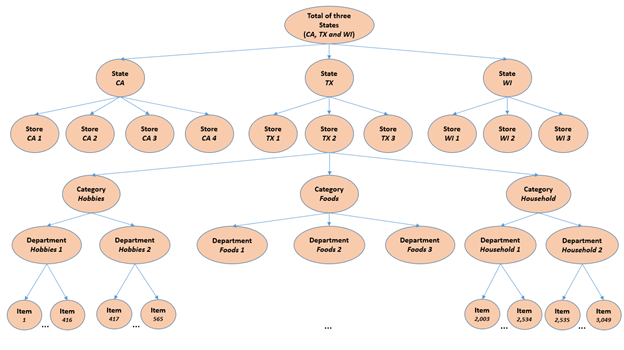

In [1]:
from IPython.display import display, Image
display(Image(filename='Figure1.png',width=700))

<b><u>File Description</u></b>

The data comprises of **three (3) files**:

`sales_train.csv`: contains the historical daily unit sales data per product and store:
- *item_id*: The id of the product
- *dept_id*: The id of the department the product belongs to
- *cat_id*: The id of the category the product belongs to
- *store_id*: The id of the store where the product is sold
- *state_id*: The State where the store is located
- *d_1, d_2, ... , d_i, ... d_1941*: The number of units sold at day $i$, starting from 2011-01-29. 


`sell_prices.csv` contains information about the price of the products sold per store and the date:
- *store_id*: The id of the store where the product is sold 
- *item_id*: The id of the product
- *wm_yr_wk*: The id of the week
- *sell_price*: The price of the product for the given week/store (average across seven days)


`calendar.csv` contains information about the dates the products are sold:
- *date*: The date in a "y-m-d" format
- *wm_yr_wk*: The id of the week the date belongs to
- *weekday*: The type of the day (Saturday, Sunday, ..., Friday)
- *wday*: The id of the weekday, starting from Saturday
- *month*: The month of the date
- *year*: The year of the date
- *event_name_1*: If the date includes an event, the name of this event
- *event_type_1*: If the date includes an event, the type of this event
- *event_name_2*: If the date includes a second event, the name of this event
- *event_type_2*: If the date includes a second event, the type of this event
- *snap_CA*, *snap_TX*, and *snap_WI*: Three binary variables indicating whether the stores in CA, TX or WI allow SNAP  purchases at this date (1) or not (0)


<b><u>Evaluation Metric</u></b>

The point forecast submission is evaluated using **Root Mean Squared Scaled Error (RMSSE)**.

<a name="downcast"></a>
## Loading and downcasting data

Downcasting the dataframes helps to reduce the amount of storage used by them in order to facilitate operations performed on them.

In this dataset, we downcast features with float64 data type into float32 data type, and features with either int64 or int32 data type to int16 data type.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

train_sales = pd.read_csv('/datasets/m5-forecasting-accuracy/sales_train_evaluation.csv')
calendar = pd.read_csv('/datasets/m5-forecasting-accuracy/calendar.csv')

In [ ]:
#To reduce memory usage
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

#Reduce memory usage and compare with the previous one to be sure
train_sales = downcast_dtypes(train_sales)

In [ ]:
train_sales.head()

<a name="preprocess"></a>
## Preprocessing data

In the `sell_prices.csv` data, multiple products could report zero prices from day 1 to day 350 since these products may not be listed in the store yet.

In the `sales_train.csv` data, multiple products could also report zero sales from day 1 to day 350 since these products may report zero prices or figures for their sales are not recorded. 

Given that our deep neural network is expected to predict the future sales of multiple products concurrently instead of individually, we set our cutoff date to be day 350 and consider the sales data of all products after that date. 

In [ ]:
# Preprocess: remove id, item_id, dept_id, cat_id, store_id, state_id columns
startDay = 350  # Remove the first 350 days in train sales data due to zero_inflated data
train_sales = train_sales.T
train_sales = train_sales[6 + startDay:]
train_sales.head(5)

**Additional features: event 1, event 2 and SNAP**

Festive or sports events and SNAP programs should influence sales of the day. Hence, in addition to the time series sales data, 5 additional features are considered: event 1, event 2, SNAP_CA, SNAP_WI, SNAP_TX. Since the days of SNAP program is different for each state (i.e., CA, WI and TX), we designate 3 separate features for SNAP.  

These features are binary (i.e. 1 for the occurence of an event/SNAP day and 0 for otherwise).

In [ ]:
# Initialize a dataframe with zeros for 1969 days in the calendar

daysBeforeEvent1 = pd.DataFrame(np.zeros((1969,1)))
daysBeforeEvent2 = pd.DataFrame(np.zeros((1969,1)))

snap_CA = pd.DataFrame(np.zeros((1969,1)))
snap_TX = pd.DataFrame(np.zeros((1969,1)))
snap_WI = pd.DataFrame(np.zeros((1969,1)))


# Label 1 to one day before the event_name_1 
# Label 1 to one day before the event_name_2
# Sales are likely to increase one day before events like superbowl etc.

# Label 1 to days on snap_CA
# Label 1 to days on snap_TX
# Label 1 to days on snap_WI

for x,y in calendar.iterrows():
    if((pd.isnull(calendar["event_name_1"][x])) == False):
           daysBeforeEvent1[0][x-1] = 1 
            
    if((pd.isnull(calendar["event_name_2"][x])) == False):
           daysBeforeEvent2[0][x-1] = 1    
    
    
    if((pd.isnull(calendar["snap_CA"][x])) == False):
           snap_CA[0][x] = 1    
        
    if((pd.isnull(calendar["snap_TX"][x])) == False):
           snap_TX[0][x] = 1    
        
    if((pd.isnull(calendar["snap_WI"][x])) == False):
           snap_WI[0][x] = 1

**Creating training, validation, evaluation data**

*Training Data*
- The training data comprises of features including sales, event 1, event 2, SNAP from day 350 to 1912. 

- From this data, we predict the future sales of each product for 56 days (predict day 1913 to day 1940, and predict day 1941 to day 1969).

*Validation Data*
- The validation data comprising of the same set of features including sales, event 1, event 2, SNAP captures these figures from day 1913 to 1940 and it is used to validate the values predicted by the deep neural network trained from the training data. 

*Evaluation Data*
- The evaluation data comprising of the same set of features including sales, event 1, event 2, SNAP captures these figures from day 1941 to 1969 and it is used to evaluate the values predicted by the deep neural network trained from the training data. 

In [ ]:
# split dataset into evaluation (last 2 weeks), validation (first 2 weeks), training  
# input for predicting validation period day 1941 to 1969

daysBeforeEvent1_eval = daysBeforeEvent1[1941:]
daysBeforeEvent2_eval = daysBeforeEvent2[1941:]

snap_CA_eval = snap_CA[1941:]
snap_TX_eval = snap_TX[1941:]
snap_WI_eval = snap_WI[1941:]


# input for predicting validation period day 1913 to 1941

daysBeforeEvent1_valid = daysBeforeEvent1[1913:1941] 
daysBeforeEvent2_valid = daysBeforeEvent2[1913:1941]

snap_CA_valid = snap_CA[1913:1941] 
snap_TX_valid = snap_TX[1913:1941]
snap_WI_valid = snap_WI[1913:1941]

# input for training as a feature
# daysBeforeEvent1 = daysBeforeEvent1[startDay:1913] 
# daysBeforeEvent2 = daysBeforeEvent2[startDay:1913] 
daysBeforeEvent1 = daysBeforeEvent1[startDay:1941] 
daysBeforeEvent2 = daysBeforeEvent2[startDay:1941]

snap_CA = snap_CA[startDay:1941] 
snap_TX = snap_TX[startDay:1941] 
snap_WI = snap_WI[startDay:1941] 

In [ ]:
#Before concatanation with our main data "dt", indexes are made same and column name is changed to "oneDayBeforeEvent"
daysBeforeEvent1.columns = ["oneDayBeforeEvent1"]
daysBeforeEvent1.index = train_sales.index

daysBeforeEvent2.columns = ["oneDayBeforeEvent2"]
daysBeforeEvent2.index = train_sales.index


snap_CA.columns = ["snap_CA"]
snap_CA.index = train_sales.index

snap_TX.columns = ["snap_TX"]
snap_TX.index = train_sales.index

snap_WI.columns = ["snap_WI"]
snap_WI.index = train_sales.index

In [ ]:
train_sales = pd.concat([train_sales, daysBeforeEvent1, daysBeforeEvent2,
                        snap_CA, snap_TX, snap_WI], axis = 1, sort=False)
train_sales.head()  # additional features (event1, event2, SNAP) are added

**Standardizing features**

It is also important to scale our features across the columns. Each column should represent the sales values of a particular day. This helps to ensure that sales have standardized values between 0 and 1, and faciltates the gradient descent optimization algorithm in a deep neural network model.

In [ ]:
#Feature Scaling: Scale features using min-max scaler in range 0-1
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

train_sales_scaled = sc.fit_transform(train_sales)

In [ ]:
timesteps = 28  # use the last 28 days to predict the next day's sales
X_train = []
y_train = []

for i in range(timesteps, 1941 - startDay):
    X_train.append(train_sales_scaled[i-timesteps:i])
    y_train.append(train_sales_scaled[i][0:30490])

In [ ]:
#Convert to np array to be able to feed the LSTM model
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

<a name="cnnlstm"></a>
## CNN-LSTM Model

Our model is CNN-LSTM, which includes regularization and batch normalization. There are 2 layers of CNN in which each conv1d layer is succeeded by a max pooling layer. The conv1d layer extract the sequential patterns of sales in a 1 week window while the max pooling layer summarizes these patterns into broader and more generalizable patterns. 

Outputs from the CNN are fed into 3 layers of bidirectional LSTM. Between each layer of bidirectional LSTM, a layer of batch normalization is added for regularization. 

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout

tf.random.set_seed(51)
np.random.seed(51)

n_timesteps = X_train.shape[1]
n_products = X_train.shape[2]


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=7,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=(n_timesteps, n_products)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(filters=64, kernel_size=7, 
                           strides=1, activation='relu', padding="causal"),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(30490)
])


opt_adam = tf.keras.optimizers.Adam(clipvalue=0.5)

model.compile(loss='mse',
              optimizer=opt_adam, 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

In [ ]:
# Fitting the RNN to the Training set
epochs = 150
batch_size = 100
model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

In [ ]:
inputs_eval = train_sales[-timesteps:]
inputs_eval = sc.transform(inputs_eval)

inputs = train_sales[-timesteps*2:-timesteps]
inputs = sc.transform(inputs)

<a name="prediction"></a>
## Predicting future sales for validation and evaluation periods

In [ ]:
X_test = []
X_test.append(inputs[0:timesteps])
X_test = np.array(X_test)
predictions = []

for j in range(timesteps,timesteps + 28):
    predicted_stock_price = model.predict(X_test[0,j - timesteps:j].reshape(1, timesteps, 30495))
    
    testInput = np.column_stack((np.array(predicted_stock_price),
                                 daysBeforeEvent1_valid.loc[1913 + j - timesteps],
                                 daysBeforeEvent2_valid.loc[1913 + j - timesteps],
                                 snap_CA_valid.loc[1913 + j - timesteps],
                                snap_TX_valid.loc[1913 + j - timesteps],
                                snap_WI_valid.loc[1913 + j - timesteps]))

    predicted_stock_price = sc.inverse_transform(testInput)[:,0:30490]
    predictions.append(predicted_stock_price)

In [ ]:
X_eval = []
X_eval.append(inputs_eval[0:timesteps])
X_eval = np.array(X_eval)
predictions_eval = []

for j in range(timesteps,timesteps + 28):
    predicted_stock_price = model2.predict(X_eval[0,j - timesteps:j].reshape(1, timesteps, 30495))
    
    testInput = np.column_stack((np.array(predicted_stock_price),
                                 daysBeforeEvent1_eval.loc[1941 + j - timesteps],
                                 daysBeforeEvent2_eval.loc[1941 + j - timesteps],
                                 snap_CA_eval.loc[1941 + j - timesteps],
                                snap_TX_eval.loc[1941 + j - timesteps],
                                snap_WI_eval.loc[1941 + j - timesteps]))

    predicted_stock_price = sc.inverse_transform(testInput)[:,0:30490]
    predictions_eval.append(predicted_stock_price)

**Post processing of future sales**

For sales with predicted negative values, they are converted into zeros. 

In [ ]:
import time

submission = pd.DataFrame(data=np.array(predictions).reshape(28,30490))
submission = submission.T

submission_eval = pd.DataFrame(data=np.array(predictions_eval).reshape(28,30490))
submission_eval = submission_eval.T

submission = pd.concat((submission, submission_eval), ignore_index=True)

sample_submission = pd.read_csv("/datasets/m5-forecasting-accuracy/sample_submission.csv")
    
idColumn = sample_submission[["id"]]
    
submission[["id"]] = idColumn  

cols = list(submission.columns)
cols = cols[-1:] + cols[:-1]
submission = submission[cols]

colsdeneme = ["id"] + [f"F{i}" for i in range (1,29)]

submission.columns = colsdeneme

currentDateTime = time.strftime("%d%m%Y_%H%M%S")

cols = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10',
       'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20',
       'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28']

submission[cols] = submission[cols].mask(submission[cols] < 0, 0)
result.to_csv("submission.csv", index=False)

<a name="references"></a>
## References

A similar version of the solution has been made [available](https://www.kaggle.com/jinghuiwong/m5-forecasting-cnn-lstm-deep-learning) on Kaggle.